# MP5: Training Your Diffusion Model!

## Setup environment

In [1]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
import torch # added
from torch import optim # added
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.transforms.v2 import GaussianNoise
import torchvision.utils as vutils
import numpy as np

In [2]:
def visualize_images_with_titles(images: torch.Tensor, column_names: list[str]):
    """
    Visualize images as a grid and title the columns with the provided names.

    Args:
        images: (N, C, H, W) tensor of images, where N is (number of rows * number of columns)
        column_names: List of column names for the titles.

    Example usage:
    visualize_images_with_titles(torch.randn(16, 1, 32, 32), ['1', '2', '3', '4'])
    """
    numimgs, num_columns = images.shape[0], len(column_names)
    assert numimgs % num_columns == 0, 'Number of images must be a multiple of the number of columns.'

    num_rows = numimgs // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 1, num_rows * 1))

    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if i < num_columns:
            ax.set_title(column_names[i % num_columns])

    plt.tight_layout()
    plt.show()


# Part 1: Training a Single-step Denoising UNet


## Implementing Simple and Composed Ops

In [3]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        #TODO: Add Num Features
        self.conv = nn.Conv2d(in_channels, out_channels,kernel_size=3,stride=1,padding=1)
        self.bnorm = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # raise NotImplementedError()
        xb = self.conv(x)
        y = self.bnorm(xb)
        convout = self.gelu(y)
        return convout


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        #TODO: Add Num Features
        self.conv = nn.Conv2d(in_channels, out_channels,kernel_size=3,stride=2,padding=1)
        self.bnorm = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        xb = self.conv(x)
        y = self.bnorm(xb)
        convout = self.gelu(y)
        return convout


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        #TODO: Add Num Features
        self.conv = nn.ConvTranspose2d(in_channels, out_channels,kernel_size=4,stride=2,padding=1)
        self.bnorm = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        xb = self.conv(x)
        y = self.bnorm(xb)
        convout = self.gelu(y)
        return convout


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.AvgPool2d(7)
        self.gelu = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # raise NotImplementedError()
        x = self.pool(x)
        flatout = self.gelu(x)
        return flatout

class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, in_channels,kernel_size=7,stride=7,padding=0)
        self.bnorm = nn.BatchNorm2d(in_channels)
        self.gelu = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # raise NotImplementedError()
        xb = self.conv(x)
        y = self.bnorm(xb)
        convout = self.gelu(y)
        return convout


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = Conv(in_channels,out_channels)
        self.conv2 = Conv(out_channels,out_channels)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # raise NotImplementedError()
        # print(x.shape)
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        return out2

class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = DownConv(in_channels,out_channels)
        self.conv2 = ConvBlock(out_channels,out_channels)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        return out2


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = UpConv(in_channels,out_channels)
        self.conv2 = ConvBlock(out_channels,out_channels)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        return out2

## Implementing Unconditional UNet

In [4]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.convb1 = ConvBlock(in_channels,num_hiddens)
        self.downb1 = DownBlock(num_hiddens,num_hiddens)
        self.downb2 = DownBlock(num_hiddens,num_hiddens*2)
        self.flat1 = Flatten()
        self.unflat1 = Unflatten(num_hiddens*2)
        #Concat w/ downb2
        self.upb1 = UpBlock(num_hiddens*4,num_hiddens)
        #Concat w/ downb1
        self.upb2 = UpBlock(num_hiddens*2,num_hiddens)
        #Concat w/ convb1
        self.convb2 = ConvBlock(num_hiddens*2,num_hiddens)
        self.convf = Conv(num_hiddens,in_channels)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # print(x.shape)
        convb1   = self.convb1(x)
        downb1   = self.downb1(convb1)
        downb2   = self.downb2(downb1)
        flat1    = self.flat1(downb2)
        unflat1  = self.unflat1(flat1)
        concat1 = torch.cat((downb2,unflat1),dim=1)
        upb1 = self.upb1(concat1)
        concat2 = torch.cat((downb1,upb1),dim=1)
        upb2 = self.upb2(concat2)
        concat3 = torch.cat((convb1,upb2),dim=1)
        convb2 = self.convb2(concat3)
        convf = self.convf(convb2)
        return convf

## Visualizing the noising process

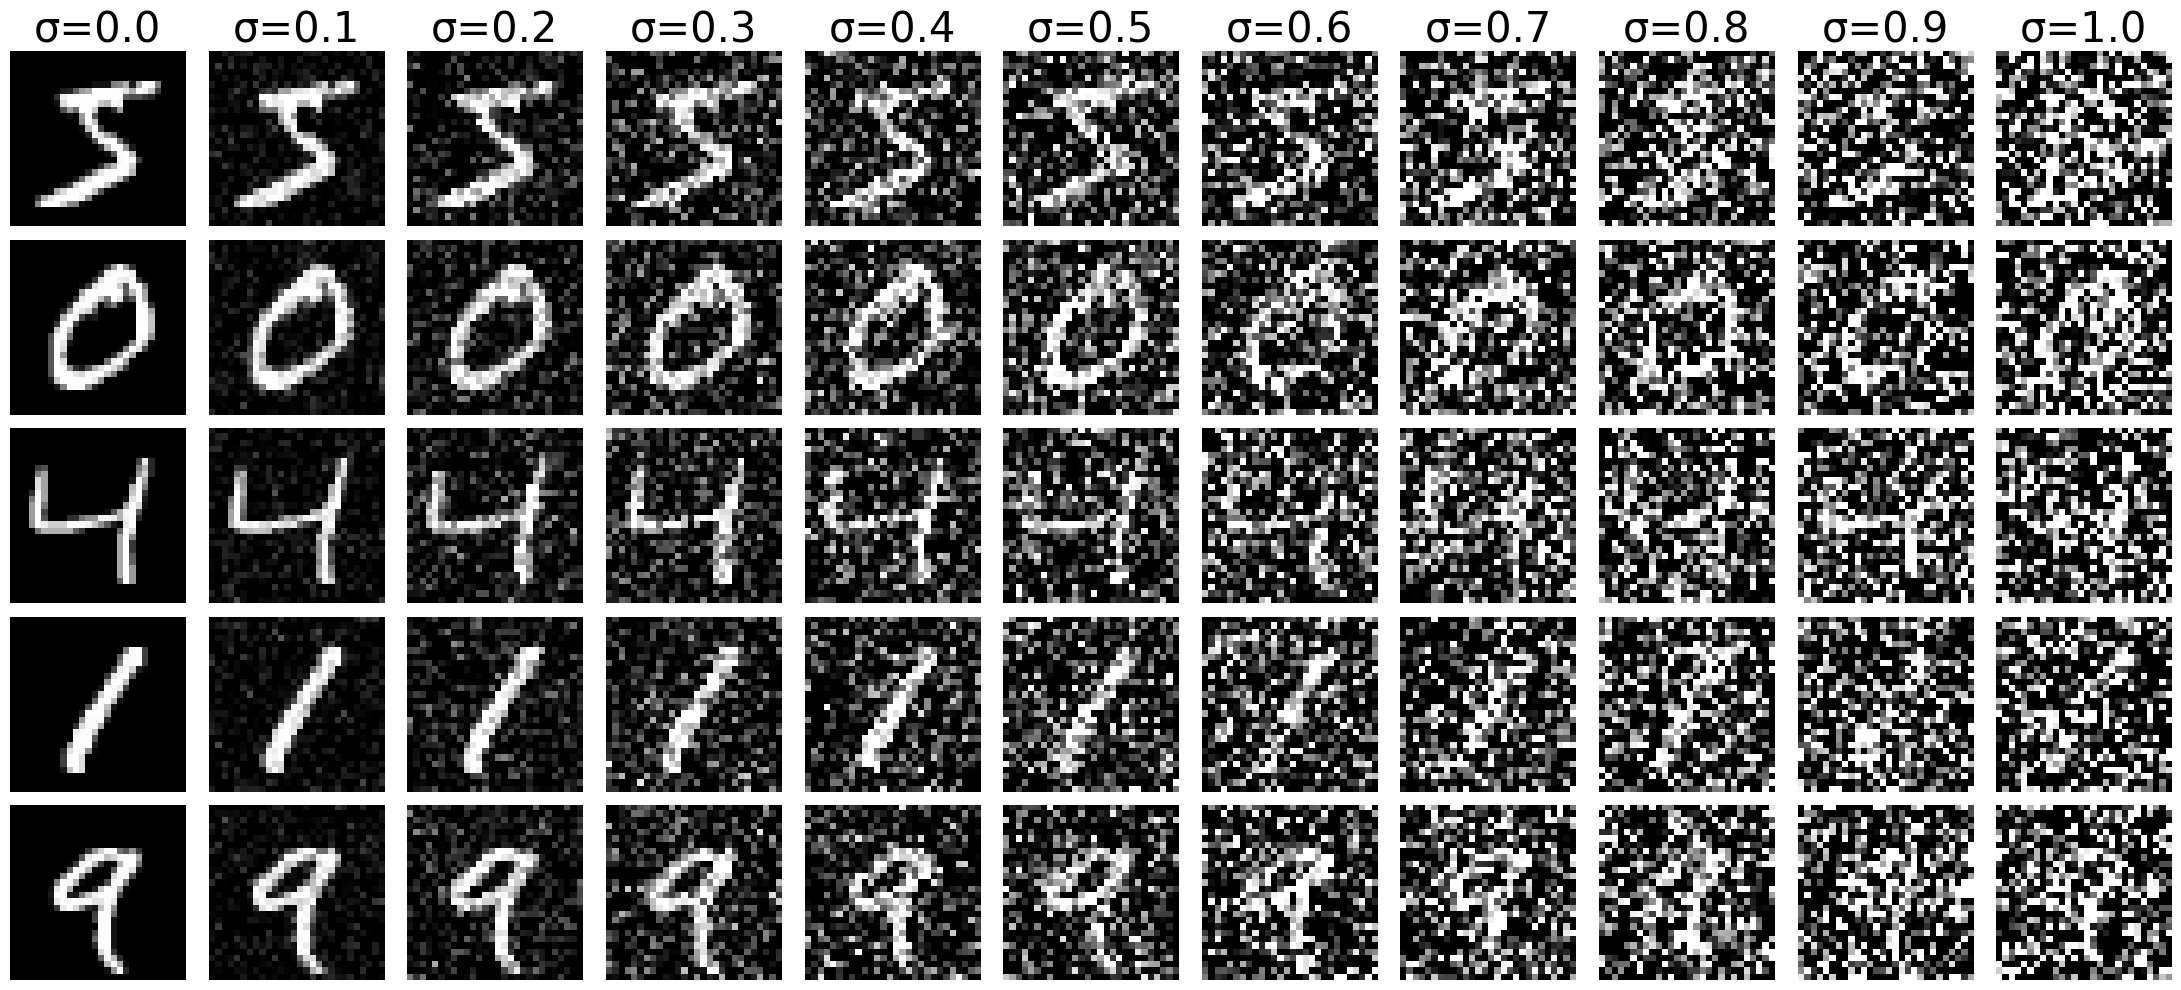

In [5]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

dataset = MNIST(root="data", download=True, transform=ToTensor(), train=True)
sigma = np.arange(0,11)/10
# img, _ = dataset[0]  # img shape: [1, 28, 28]

# Define noise levels
sigma_values = np.arange(0, 11) / 10 
numimgs = 5
images = torch.stack([dataset[i][0] for i in range(numimgs)])  # shape: [N, 1, 28, 28]
fig, axs = plt.subplots(numimgs, 11, figsize=(11 * 2, numimgs * 2))
for col, sigma in enumerate(sigma_values):
    noise_transform = GaussianNoise(sigma=sigma)
    noisy_images = torch.stack([noise_transform(img) for img in images])

    for row in range(numimgs):
        axs[row, col].imshow(noisy_images[row].squeeze(0), cmap='gray')
        axs[row, col].axis('off')
        if row == 0:
            axs[row, col].set_title(f"σ={sigma:.1f}", fontsize=30)

plt.tight_layout()
plt.show()
# TODO

## Training a Single-Step Unconditional UNet

- Plot the loss curve
- Sample results on the test set

In [6]:
# traindata = MNIST(root="data", download=True, transform=ToTensor(), train=True)


In [9]:
from tqdm import tqdm 
# traindata = MNIST(root="data", download=True, transform=ToTensor(), train=True)
trainloader = DataLoader(dataset,batch_size=256,shuffle=True,num_workers=12)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UnconditionalUNet(in_channels=1,num_hiddens=128).to(device)

criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-4)


model.train()
running_loss = 0.0
noise_transform = GaussianNoise(sigma=0.5)
total_loss = []
model.train()

for epoch in range(5):
    epoch_loss = 0.0
    for images, _ in tqdm(trainloader):
        images = images.to(device)

        # Apply v2 transform manually inside loop
        noisy_images = noise_transform(images)

        outputs = model(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        # running_loss += loss.item()
        avg_loss = epoch_loss / len(trainloader)
        total_loss.append(avg_loss)
    print(f"Epoch {epoch+1} Loss: {epoch_loss / len(trainloader):.4f}")
# TODO

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 235/235 [00:42<00:00,  5.59it/s]


Epoch 1 Loss: 0.0238


100%|██████████| 235/235 [00:41<00:00,  5.62it/s]


Epoch 2 Loss: 0.0113


100%|██████████| 235/235 [00:41<00:00,  5.66it/s]


Epoch 3 Loss: 0.0097


100%|██████████| 235/235 [00:41<00:00,  5.64it/s]


Epoch 4 Loss: 0.0090


100%|██████████| 235/235 [00:41<00:00,  5.65it/s]

Epoch 5 Loss: 0.0087


## Out-of-Distribution Testing

In [11]:
# TODO
model.eval()
sigma_values = np.arange(0, 11) / 10 
testdata= MNIST(root="data", download=True, transform=ToTensor(), train=False)
testloader =  DataLoader(testdata,batch_size=256,shuffle=True,num_workers=12)
sigmaloss =[]
with torch.no_grad():
    for sigma in sigma_values:
        noise_transform = GaussianNoise(mean=0.0, sigma=sigma)
        total_loss = 0.0
        shown = False
        for images, _ in tqdm(testloader, desc=f"σ={sigma:.1f}"):
            images = images.to(device)
            noisy_images = noise_transform(images)
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            total_loss += loss.item()
            if not shown:
              i = torch.randint(0, images.size(0), (1,)).item()
              noisy = noisy_images[i]
              output = outputs[i]

              vutils.save_image(noisy, f"noisy_sigma_{sigma:.1f}.png", normalize=True)
              vutils.save_image(output, f"output_sigma_{sigma:.1f}.png", normalize=True)
              shown = True

        avg_loss = total_loss / len(testloader)
        sigmaloss.append(avg_loss)
        print(f"Sigma={sigma:.2f} | Avg Test Loss: {avg_loss:.4f}")

σ=0.0: 100%|██████████| 40/40 [00:02<00:00, 15.19it/s]


Sigma=0.00 | Avg Test Loss: 0.0029


σ=0.1: 100%|██████████| 40/40 [00:02<00:00, 15.15it/s]


Sigma=0.10 | Avg Test Loss: 0.0031


σ=0.2: 100%|██████████| 40/40 [00:02<00:00, 15.08it/s]


Sigma=0.20 | Avg Test Loss: 0.0037


σ=0.3: 100%|██████████| 40/40 [00:02<00:00, 15.31it/s]


Sigma=0.30 | Avg Test Loss: 0.0048


σ=0.4: 100%|██████████| 40/40 [00:02<00:00, 15.09it/s]


Sigma=0.40 | Avg Test Loss: 0.0063


σ=0.5: 100%|██████████| 40/40 [00:02<00:00, 15.37it/s]


Sigma=0.50 | Avg Test Loss: 0.0085


σ=0.6: 100%|██████████| 40/40 [00:02<00:00, 15.44it/s]


Sigma=0.60 | Avg Test Loss: 0.0118


σ=0.7: 100%|██████████| 40/40 [00:02<00:00, 15.15it/s]


Sigma=0.70 | Avg Test Loss: 0.0167


σ=0.8: 100%|██████████| 40/40 [00:02<00:00, 14.43it/s]


Sigma=0.80 | Avg Test Loss: 0.0232


σ=0.9: 100%|██████████| 40/40 [00:02<00:00, 14.51it/s]


Sigma=0.90 | Avg Test Loss: 0.0303


σ=1.0: 100%|██████████| 40/40 [00:02<00:00, 15.58it/s]

Sigma=1.00 | Avg Test Loss: 0.0377


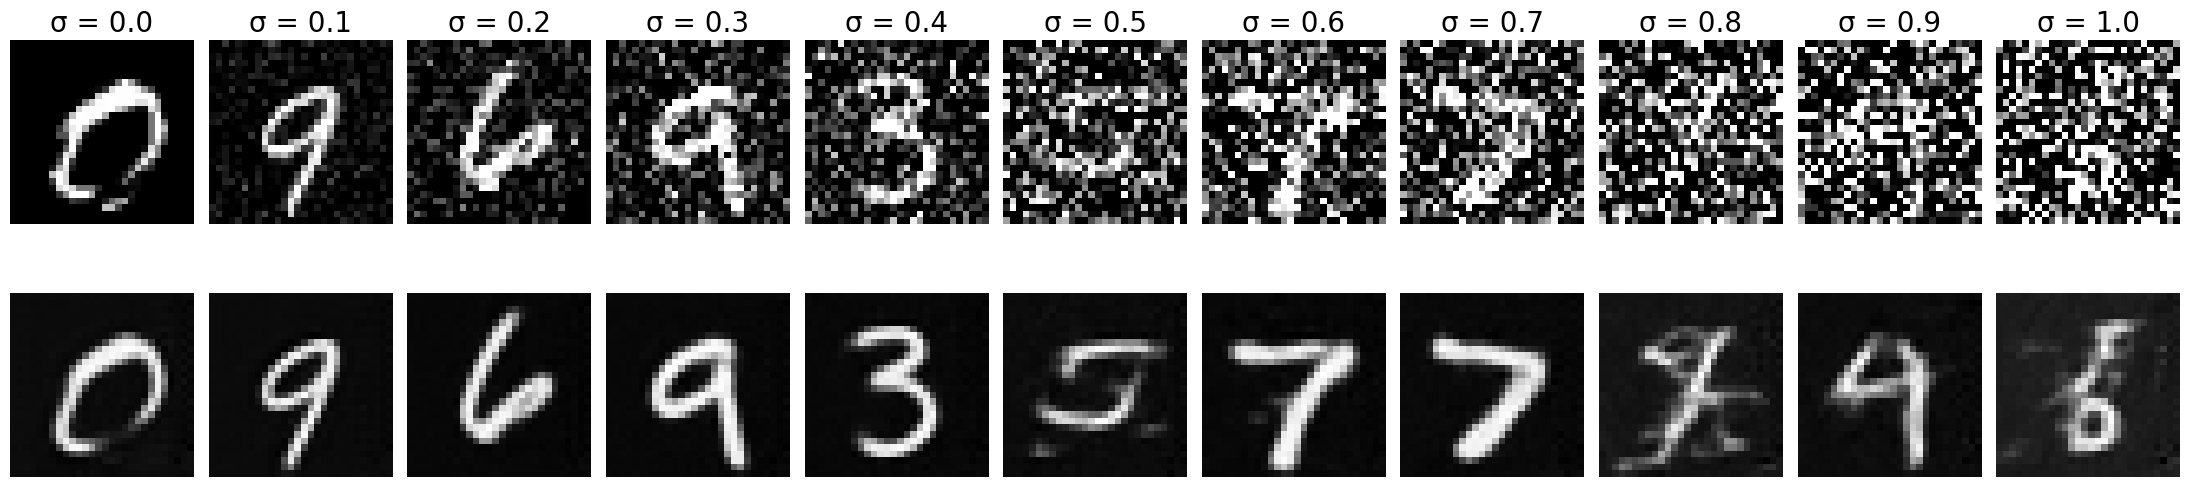

In [18]:
from PIL import Image
fig, axes = plt.subplots(2, len(sigma_values), figsize=(2 * len(sigma_values), 6))
n_cols = len(sigma_values)

for j, sigma in enumerate(sigma_values):
    sigma_str = f"{sigma:.1f}"
    noisy_img = Image.open(f"noisy_sigma_{sigma_str}.png")
    output_img = Image.open(f"output_sigma_{sigma_str}.png")
    ax_noisy = axes[0, j]
    ax_noisy.imshow(noisy_img, cmap='gray')
    ax_noisy.set_title(f"σ = {sigma_str}", fontsize=20)
    ax_noisy.axis('off')
    ax_output = axes[1, j]
    ax_output.imshow(output_img, cmap='gray')
    ax_output.axis('off')

plt.tight_layout()
plt.show()

# Part 2: Training a Diffusion Model

## Implementing a Time-conditioned UNet

In [ ]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError()


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        raise NotImplementedError()

## Implementing DDPM Forward and Inverse Process for Time-conditioned Denoising

In [ ]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."
    raise NotImplementedError()

In [ ]:
def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    raise NotImplementedError()

In [ ]:
@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    # YOUR CODE HERE.
    raise NotImplementedError()

In [ ]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

        self.ddpm_schedule = nn.ParameterDict(ddpm_schedule(betas[0], betas[1], num_ts))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed
        )

## Training the Time-conditioned UNet

- Plot the loss curve
- Sample results on the test set

In [ ]:
dataset = MNIST(root='data', download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# TODO

### Implementing class-conditioned UNet

In [ ]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        raise NotImplementedError()

In [ ]:
def ddpm_forward(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    raise NotImplementedError()

In [ ]:
@torch.inference_mode()
def ddpm_sample(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    # YOUR CODE HERE.
    raise NotImplementedError()

In [ ]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = nn.ParameterDict(ddpm_schedule(betas[0], betas[1], num_ts))

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed
        )

## Training the Class-conditioned UNet

- Plot the loss curve
- Sample results on the test set

In [ ]:
dataset = MNIST(root='data', download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# TODO